In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import glob
import os
import ta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Plot style settings
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# Load and process the raw CSV files
folder_path = '/Devs/sonia/data'
pattern = os.path.join(folder_path, '*.csv')
csv_files = glob.glob(pattern)

print(f"Found {len(csv_files)} CSV files")

Found 20 CSV files


In [39]:
# Read and clean data
dfs = []
for file in csv_files:
    try:
        df = pd.read_csv(file, parse_dates=['Date  '])
        df.columns = df.columns.str.strip()
        filename = os.path.basename(file)
        ticker = filename.split('2023-2024')[1].split('-')[0] if filename.startswith('2023-2024') else filename.split('-')[0]
        df['Ticker'] = ticker
        
        column_mapping = {
            'Open Price': 'Open',
            'High Price': 'High', 
            'Low Price': 'Low',
            'Close Price': 'Close',
            'Total Traded Quantity': 'Volume'
        }

        for old_col, new_col in column_mapping.items():
            if old_col in df.columns:
                df[new_col] = df[old_col]

        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']]
        for col in ['Open', 'High', 'Low', 'Close']:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
        df['Volume'] = pd.to_numeric(df['Volume'].astype(str).str.replace(',', ''), errors='coerce')
        df = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

        if not df.empty:
            dfs.append(df)
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [40]:
# Combine dataframes
if not dfs:
    raise ValueError("No valid stock data found.")

combined_data = pd.concat(dfs, ignore_index=True).sort_values(['Ticker', 'Date'])

In [41]:
#  Add technical indicators
def add_technical_indicators(df):
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['SMA_50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()
    df['EMA_12'] = ta.trend.EMAIndicator(df['Close'], window=12).ema_indicator()
    df['EMA_26'] = ta.trend.EMAIndicator(df['Close'], window=26).ema_indicator()
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Histogram'] = macd.macd_diff()
    bb = ta.volatility.BollingerBands(df['Close'])
    df['Bollinger_High'] = bb.bollinger_hband()
    df['Bollinger_Low'] = bb.bollinger_lband()
    df['Bollinger_Middle'] = bb.bollinger_mavg()
    df['Williams_%R'] = ta.momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    return df.dropna()

processed_dfs = []
for ticker in combined_data['Ticker'].unique():
    stock_data = combined_data[combined_data['Ticker'] == ticker].copy()
    if len(stock_data) > 50:
        processed_dfs.append(add_technical_indicators(stock_data))

final_data = pd.concat(processed_dfs, ignore_index=True).sort_values(['Ticker', 'Date'])

In [42]:
#  Create target columns
final_data['Target_1'] = (final_data['Close'].shift(-1) > final_data['Close']).astype(int)
final_data['Target_5'] = (final_data['Close'].shift(-5) > final_data['Close']).astype(int)
final_data['Target_21'] = (final_data['Close'].shift(-21) > final_data['Close']).astype(int)
final_data['Target_63'] = (final_data['Close'].shift(-63) > final_data['Close']).astype(int)
final_data['Target_126'] = (final_data['Close'].shift(-126) > final_data['Close']).astype(int)
final_data['Target_252'] = (final_data['Close'].shift(-252) > final_data['Close']).astype(int)

final_data.dropna(subset=['Target_1', 'Target_5', 'Target_21', 'Target_63', 'Target_126', 'Target_252'], inplace=True)

In [43]:
# Prepare data for modeling
features = ['SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal', 
            'MACD_Histogram', 'Bollinger_High', 'Bollinger_Low', 'Bollinger_Middle', 
            'Williams_%R', 'ATR']
targets = ['Target_1', 'Target_5', 'Target_21', 'Target_63', 'Target_126', 'Target_252']

final_data = final_data.dropna(subset=features + targets)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_data[features])

CV Accuracy for Random Forest on Target_1: 0.4944


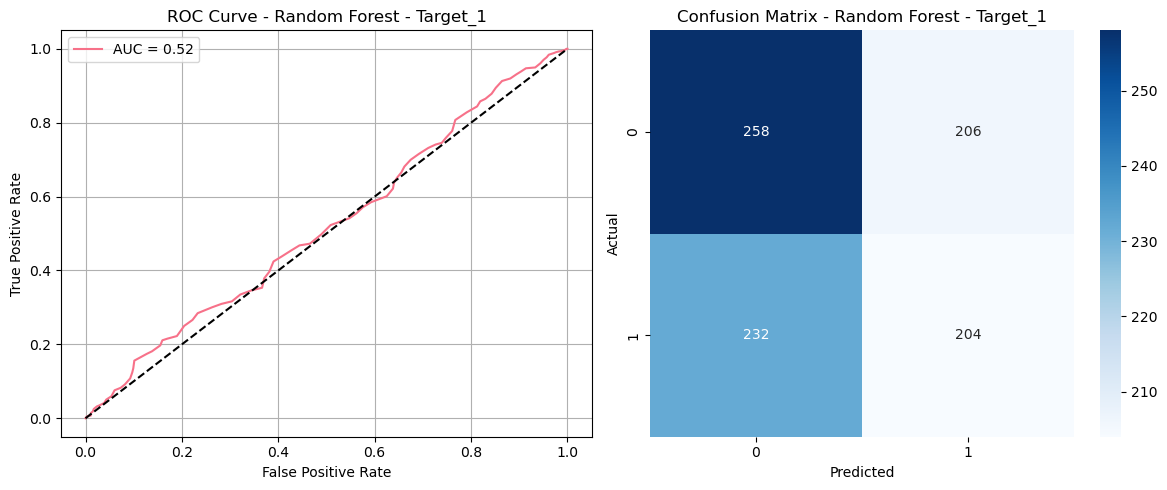

CV Accuracy for KNN on Target_1: 0.4980


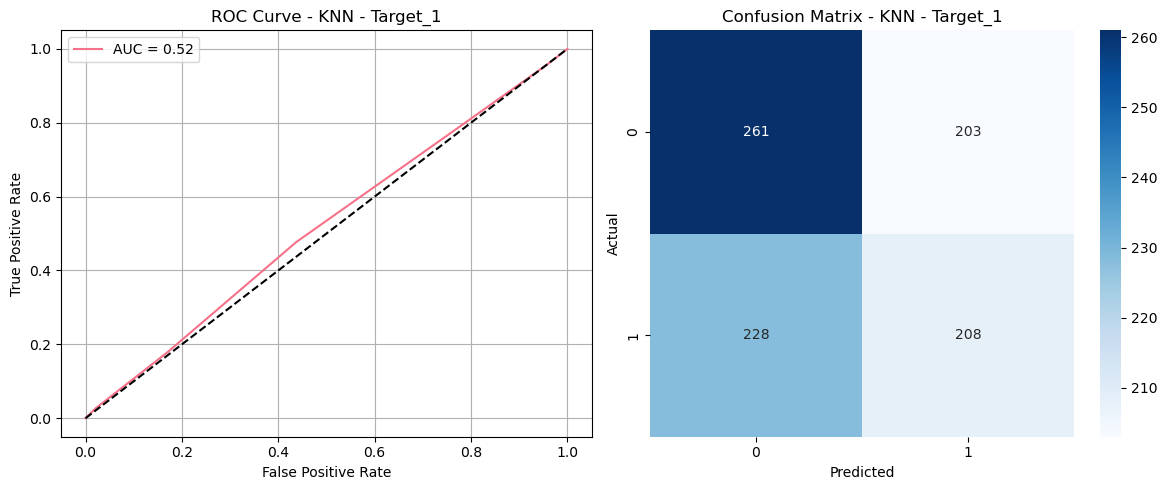

CV Accuracy for Decision Tree on Target_1: 0.4971


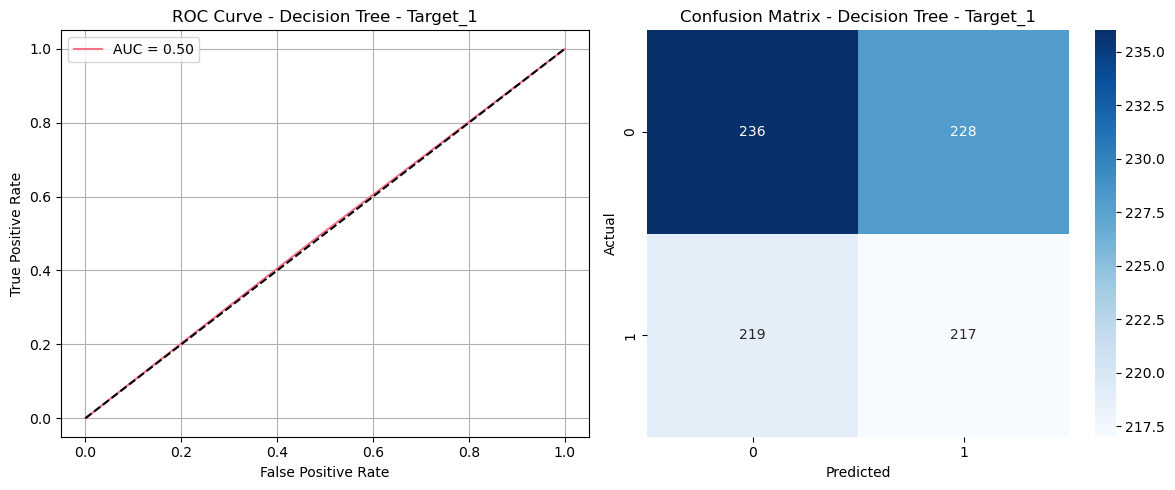

CV Accuracy for Logistic Regression on Target_1: 0.5191


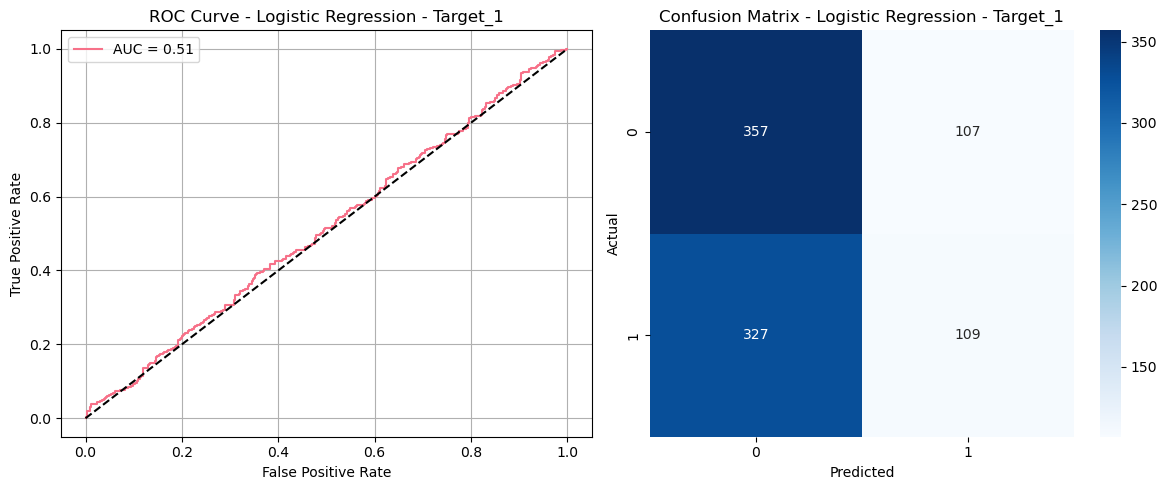

CV failed for XGBoost on Target_1: 'super' object has no attribute '__sklearn_tags__'


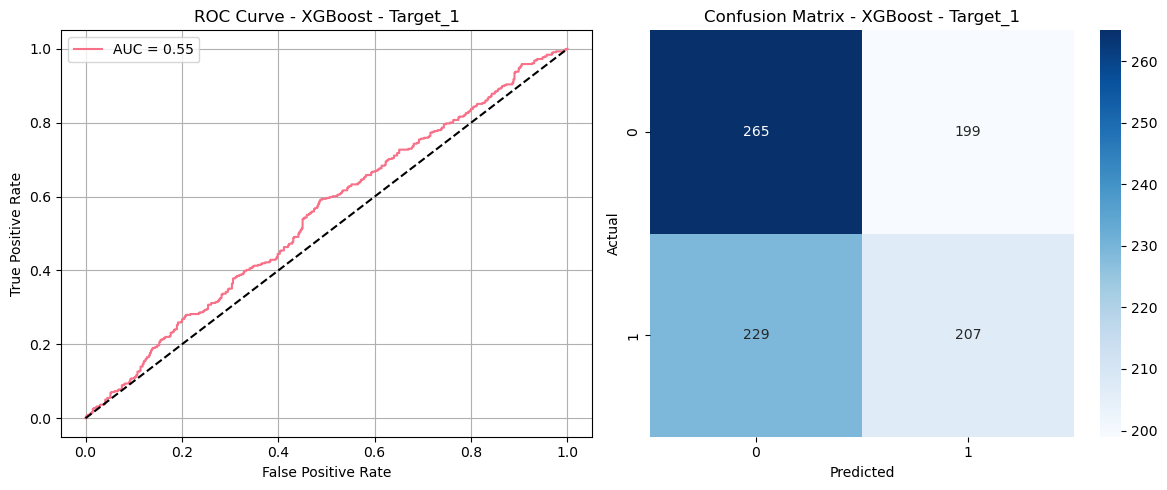

CV Accuracy for Random Forest on Target_5: 0.4809


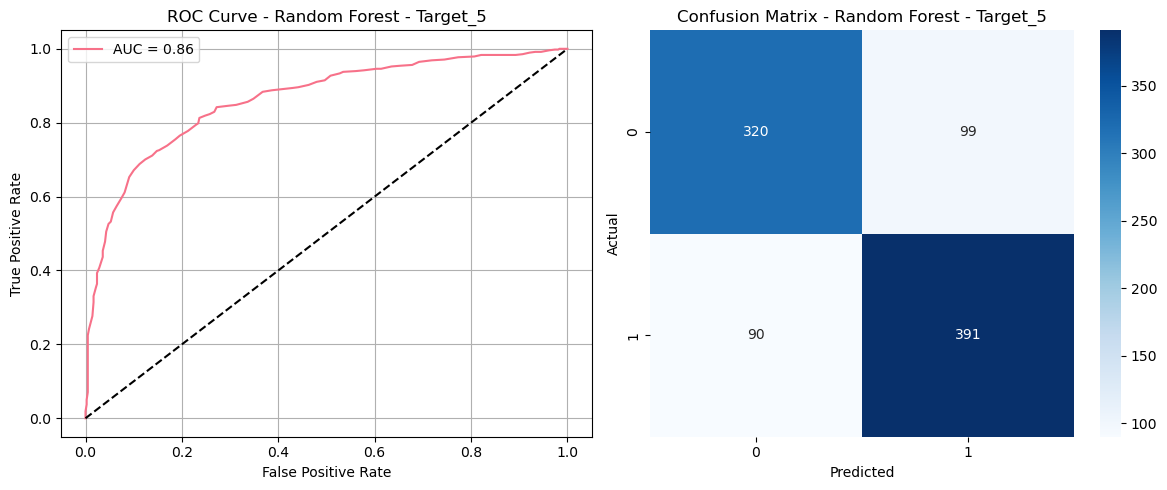

CV Accuracy for KNN on Target_5: 0.4884


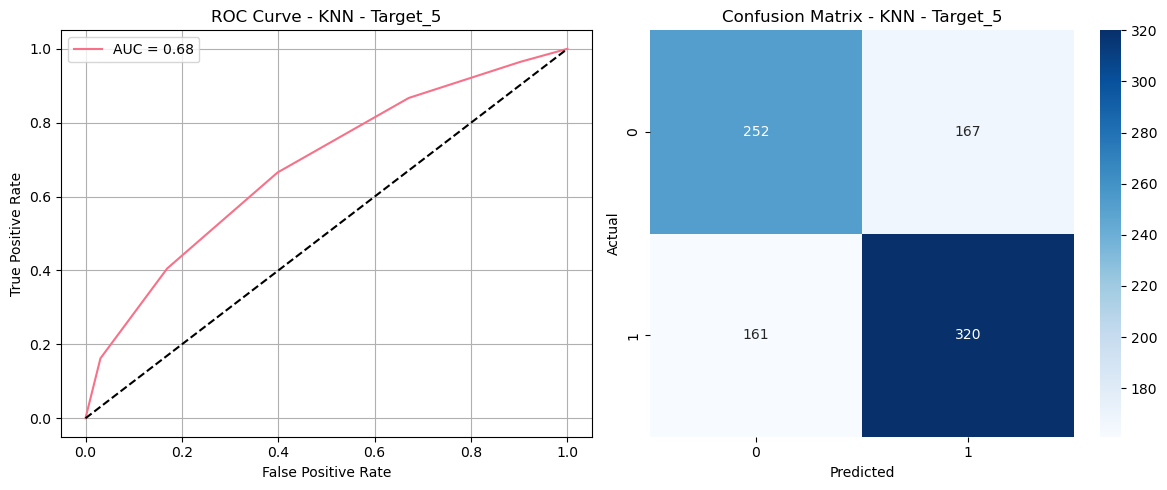

CV Accuracy for Decision Tree on Target_5: 0.4780


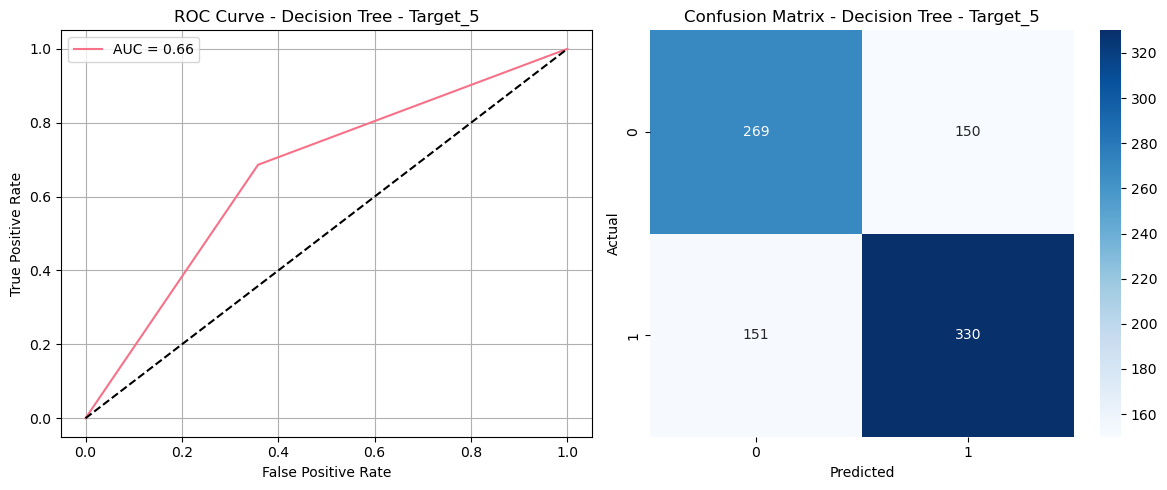

CV Accuracy for Logistic Regression on Target_5: 0.5220


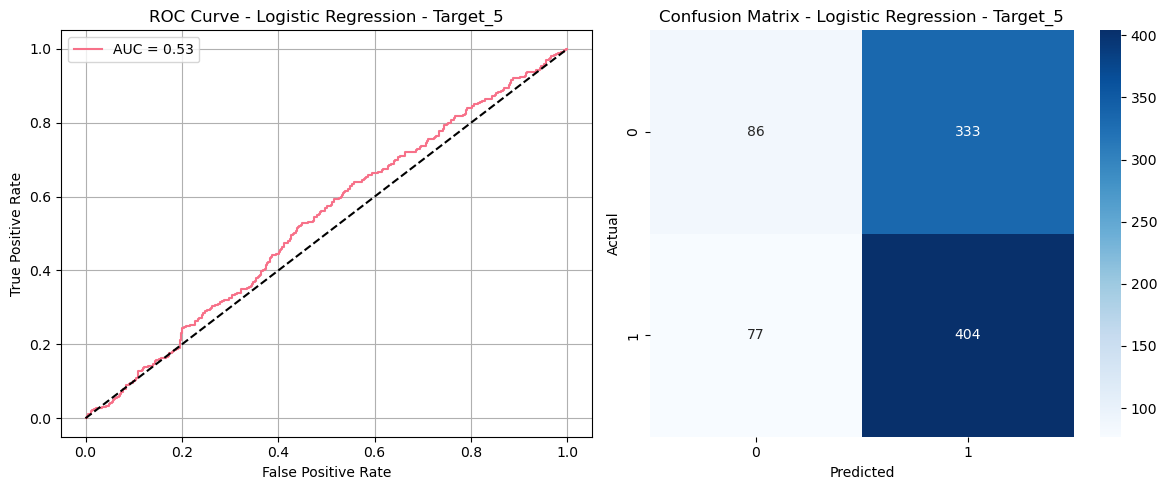

CV failed for XGBoost on Target_5: 'super' object has no attribute '__sklearn_tags__'


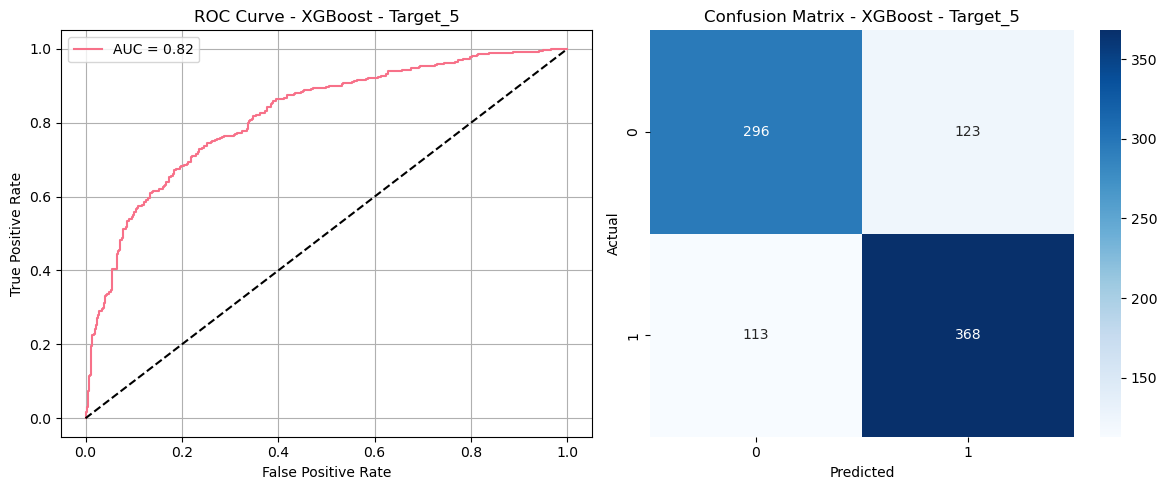

CV Accuracy for Random Forest on Target_21: 0.3924


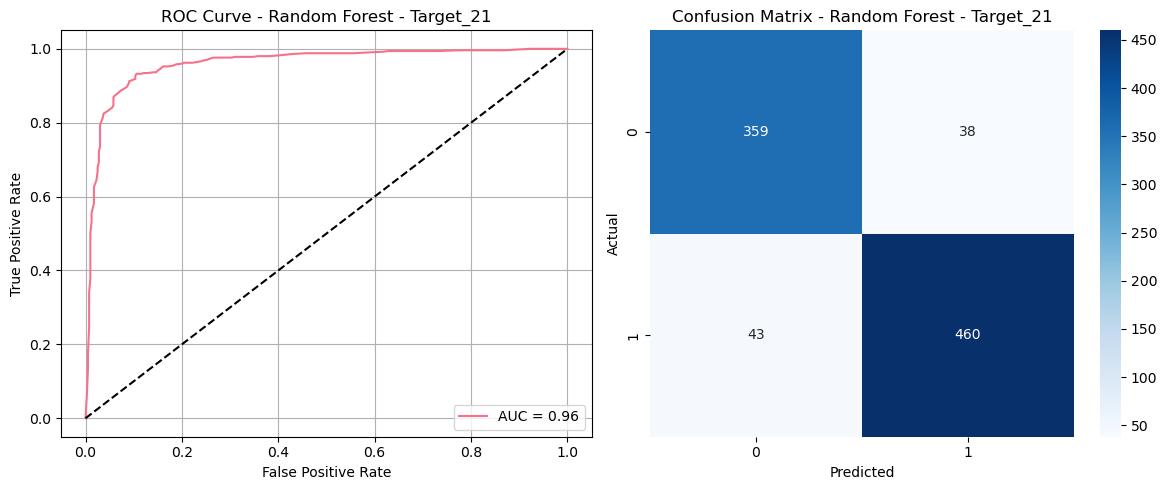

CV Accuracy for KNN on Target_21: 0.4451


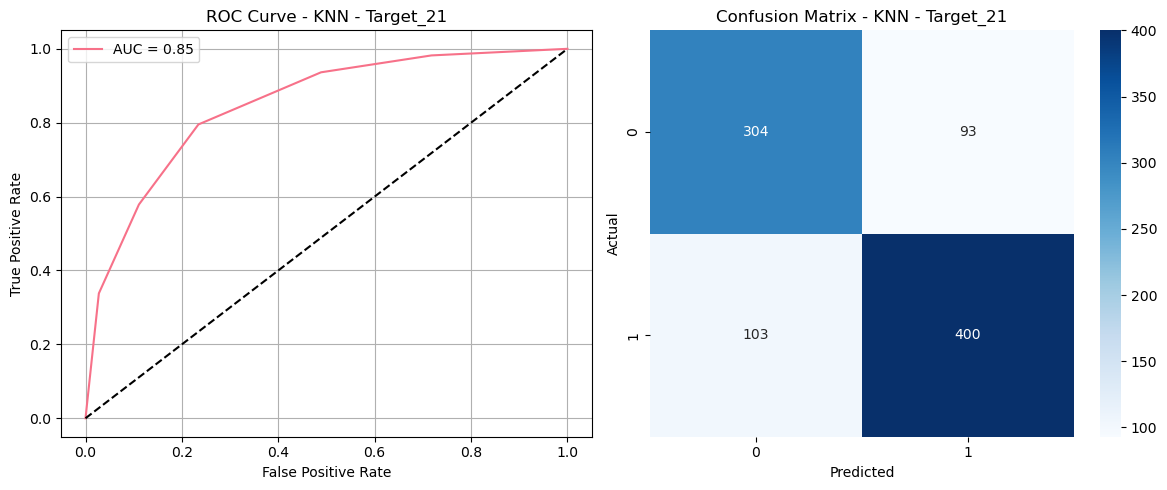

CV Accuracy for Decision Tree on Target_21: 0.4000


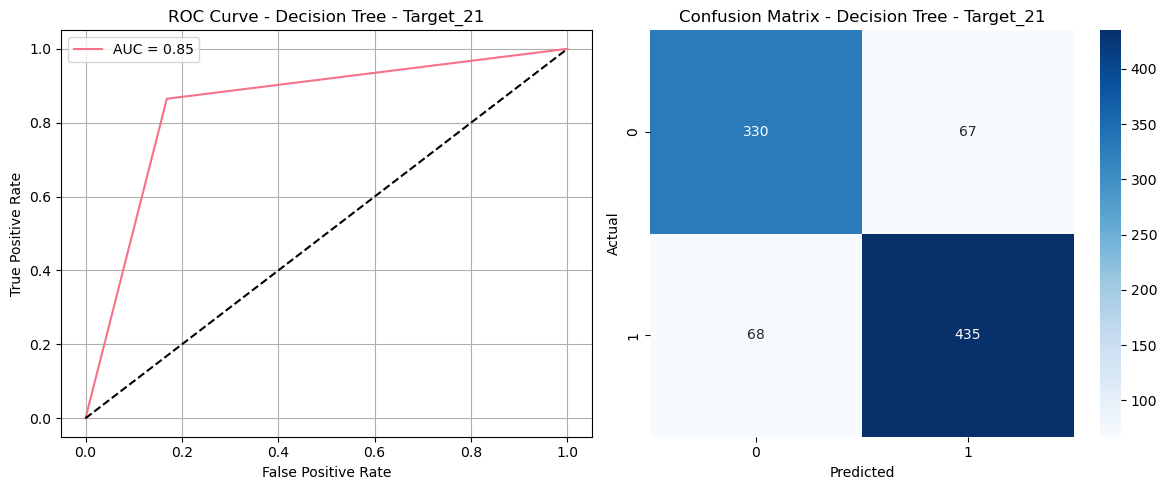

CV Accuracy for Logistic Regression on Target_21: 0.5873


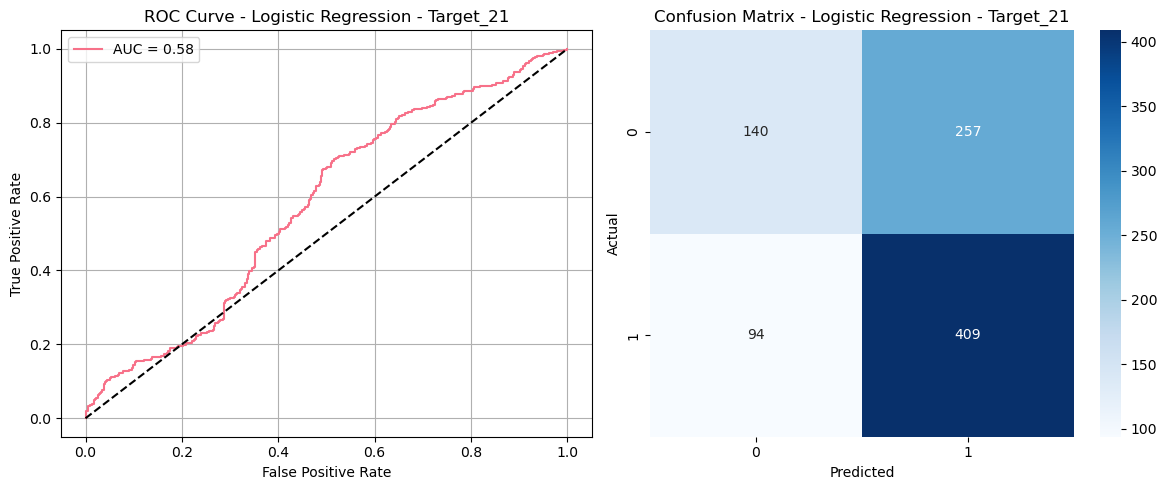

CV failed for XGBoost on Target_21: 'super' object has no attribute '__sklearn_tags__'


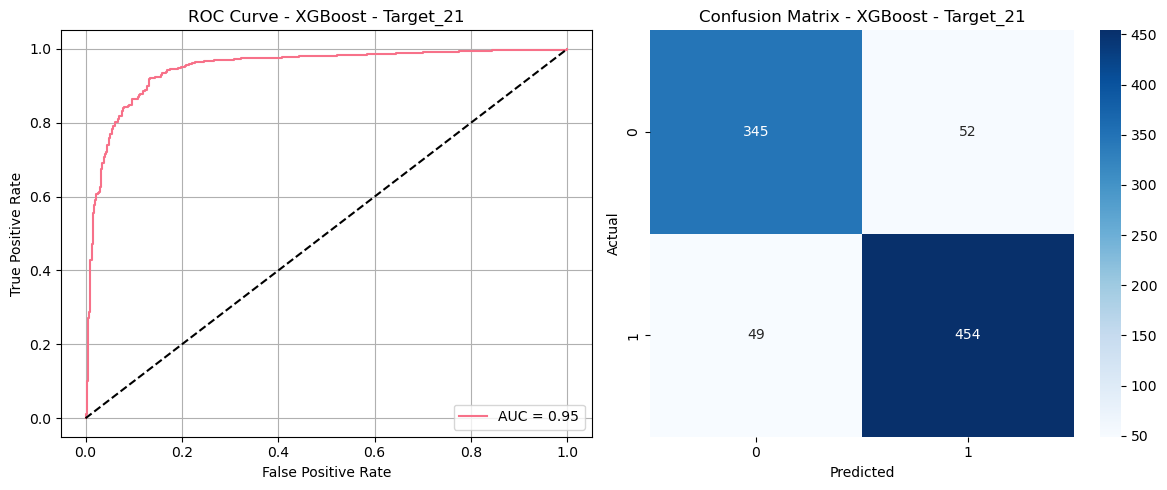

CV Accuracy for Random Forest on Target_63: 0.3904


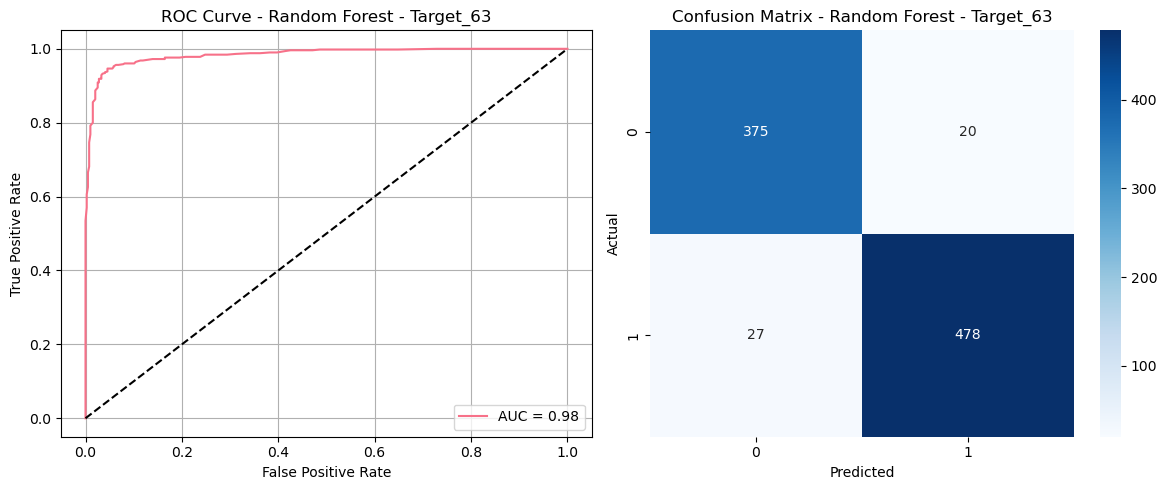

CV Accuracy for KNN on Target_63: 0.4744


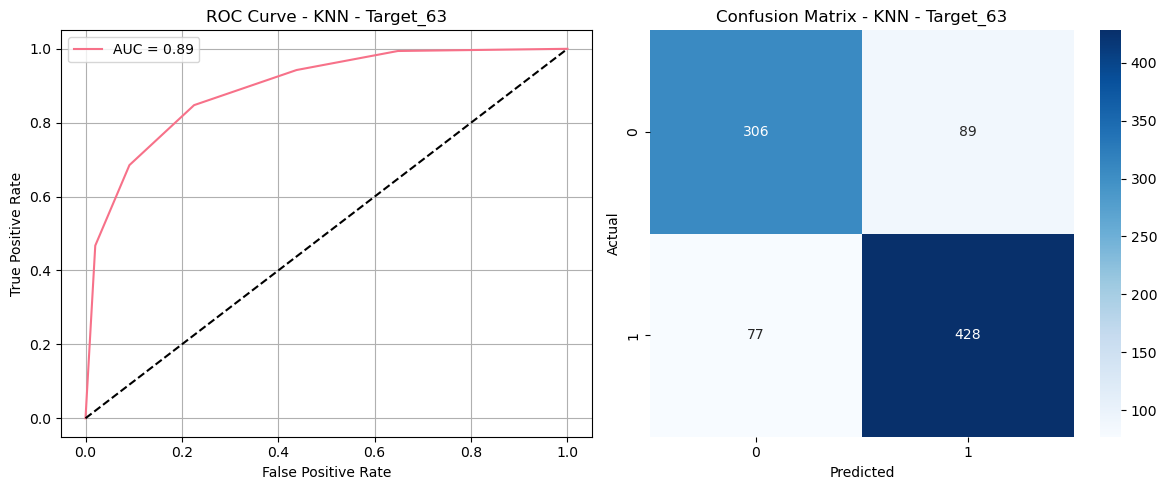

CV Accuracy for Decision Tree on Target_63: 0.3920


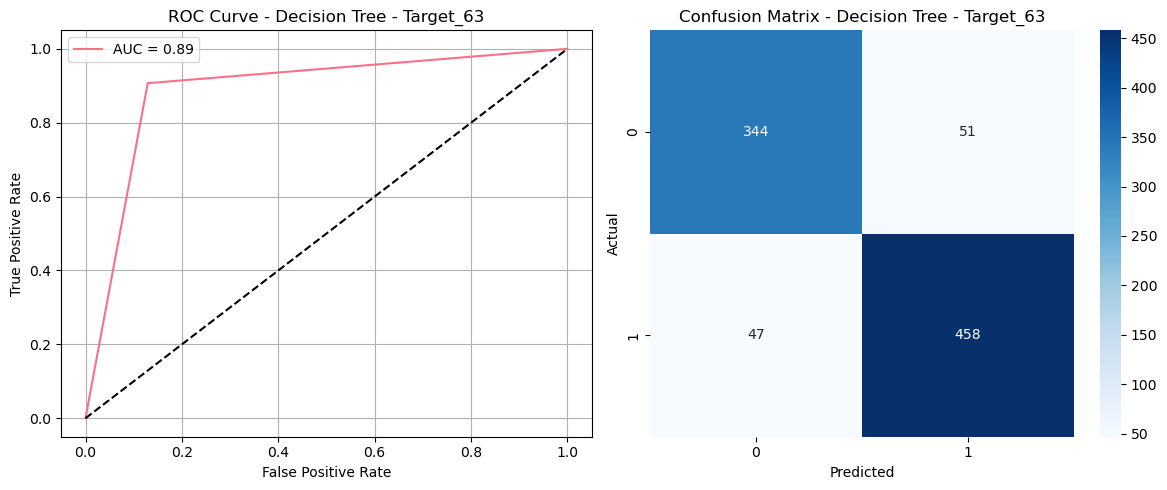

CV Accuracy for Logistic Regression on Target_63: 0.6051


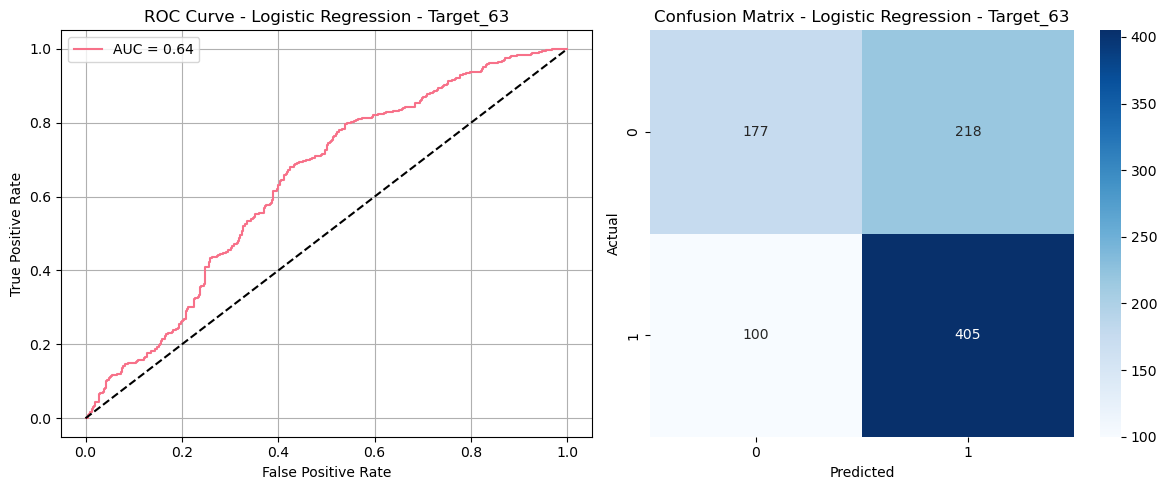

CV failed for XGBoost on Target_63: 'super' object has no attribute '__sklearn_tags__'


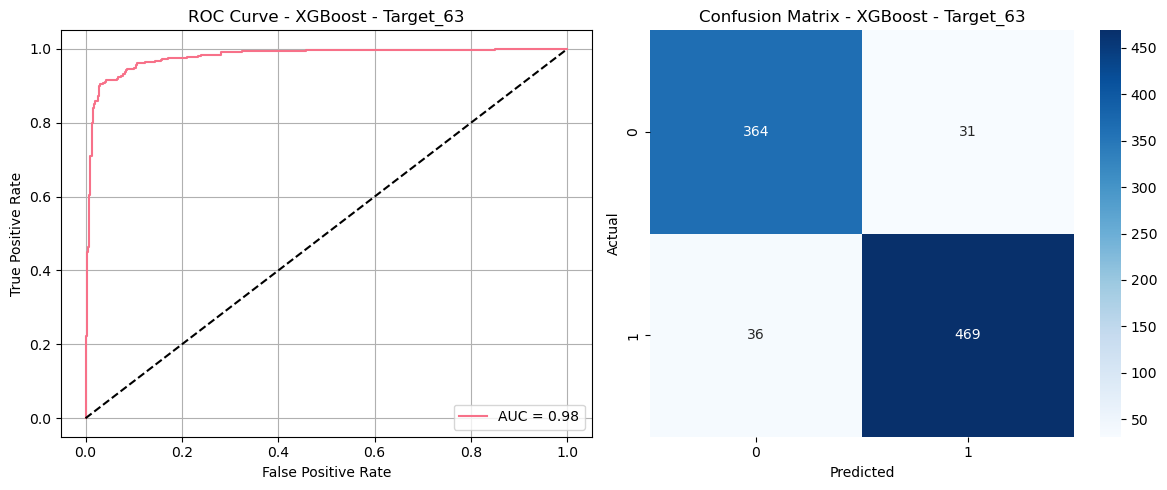

CV Accuracy for Random Forest on Target_126: 0.3191


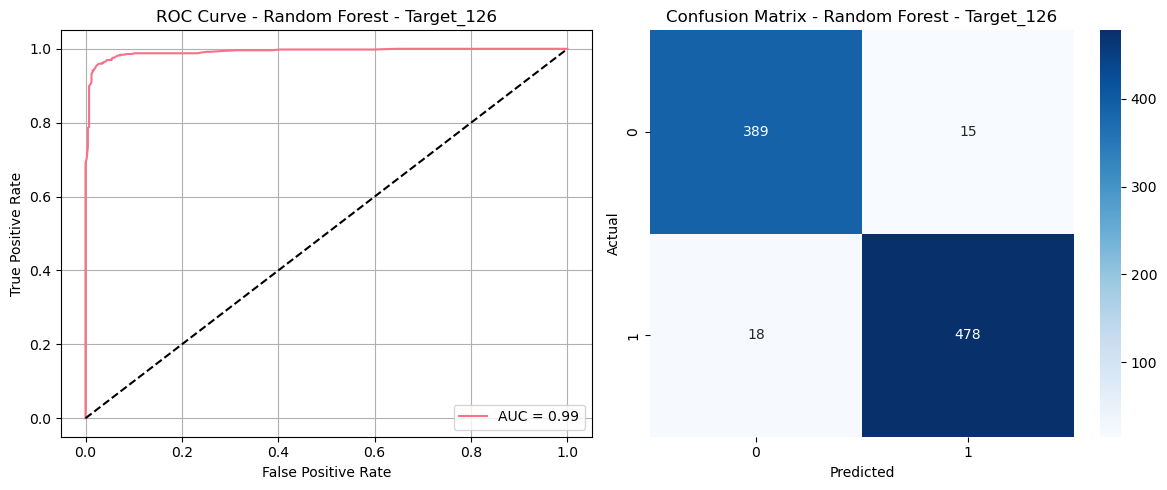

CV Accuracy for KNN on Target_126: 0.3002


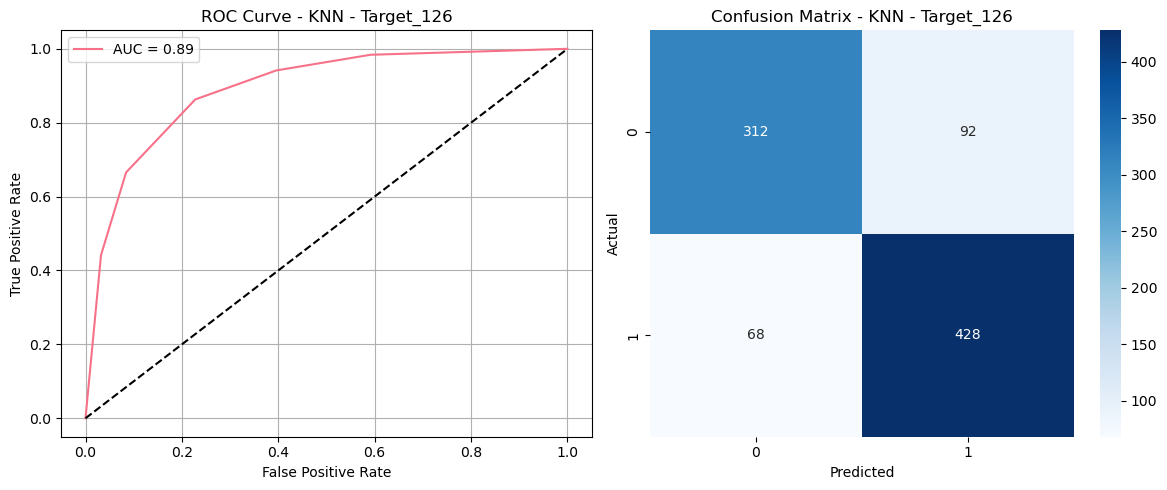

CV Accuracy for Decision Tree on Target_126: 0.3176


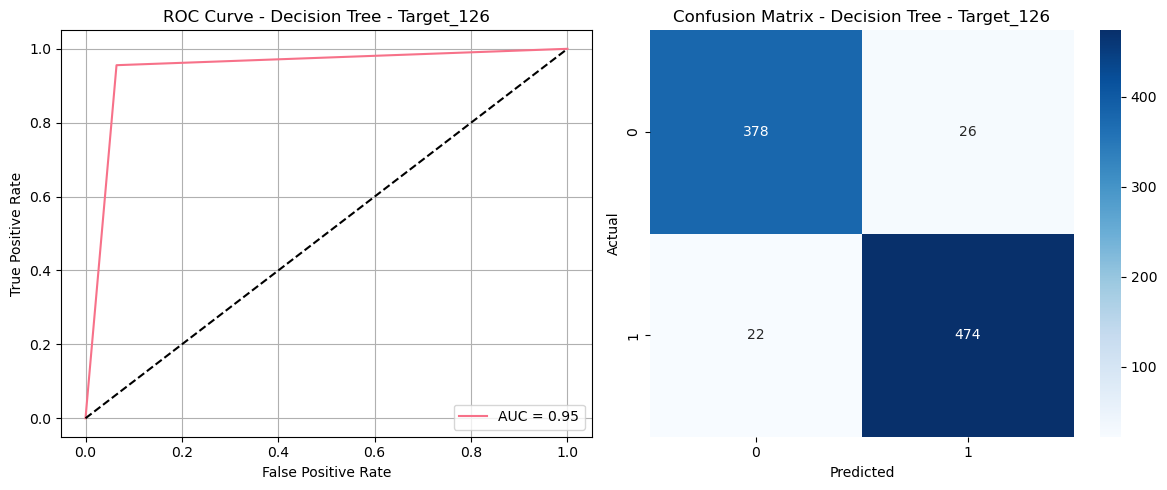

CV Accuracy for Logistic Regression on Target_126: 0.6204


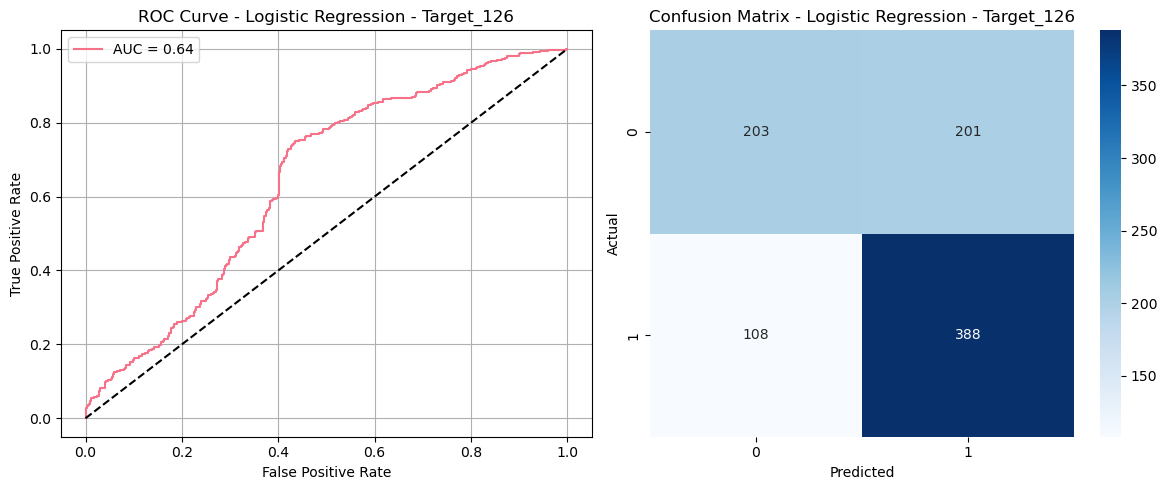

CV failed for XGBoost on Target_126: 'super' object has no attribute '__sklearn_tags__'


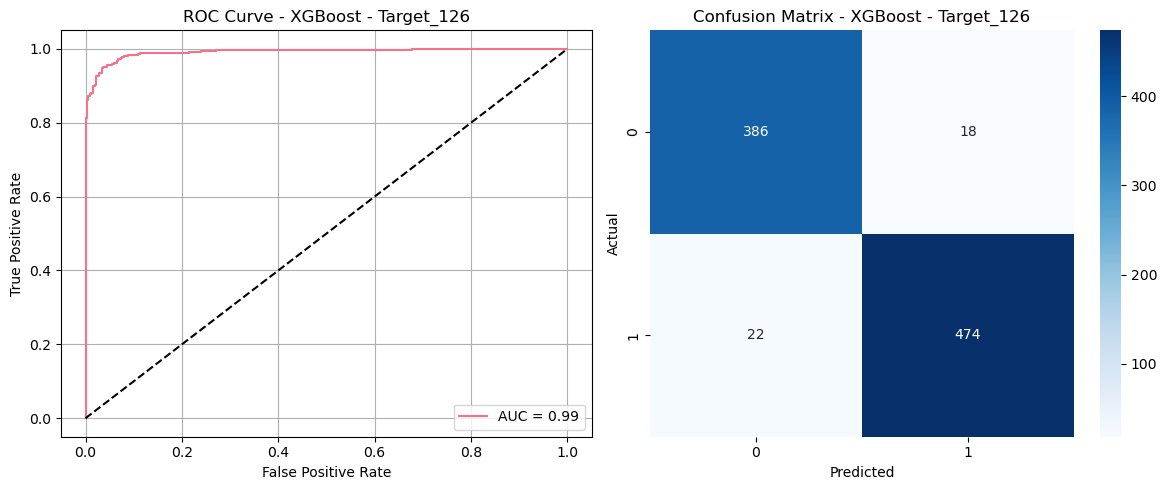

CV Accuracy for Random Forest on Target_252: 0.4216


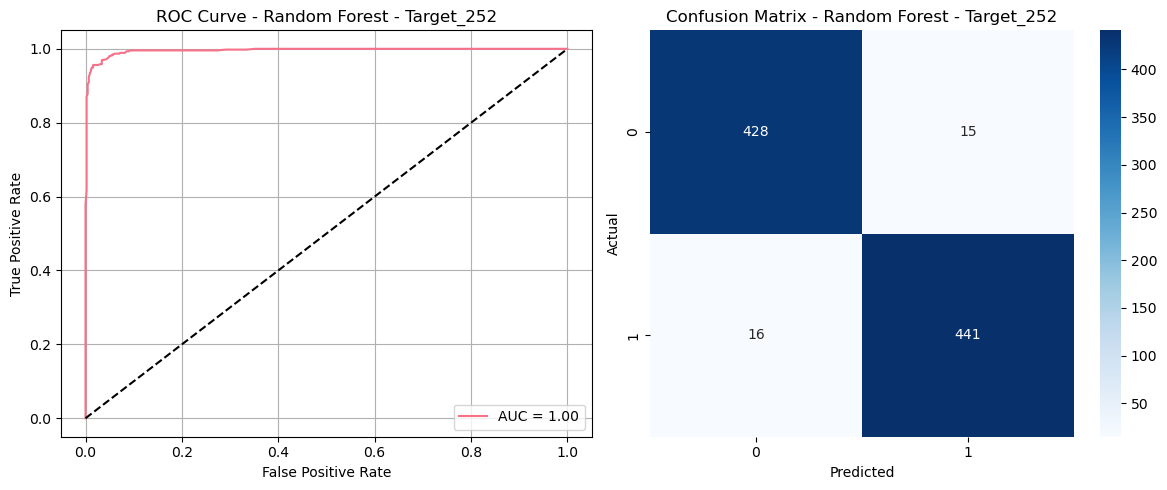

CV Accuracy for KNN on Target_252: 0.4956


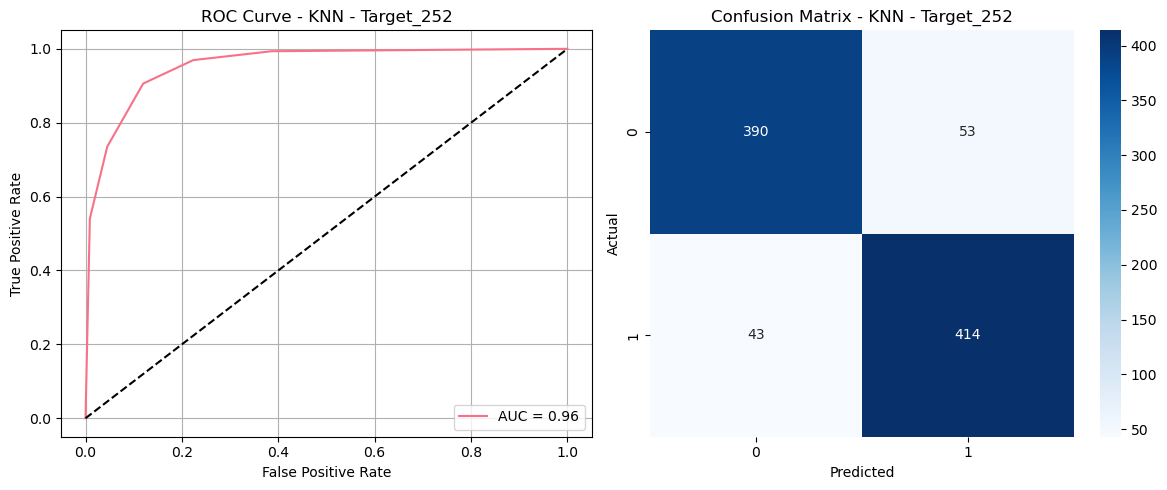

CV Accuracy for Decision Tree on Target_252: 0.5024


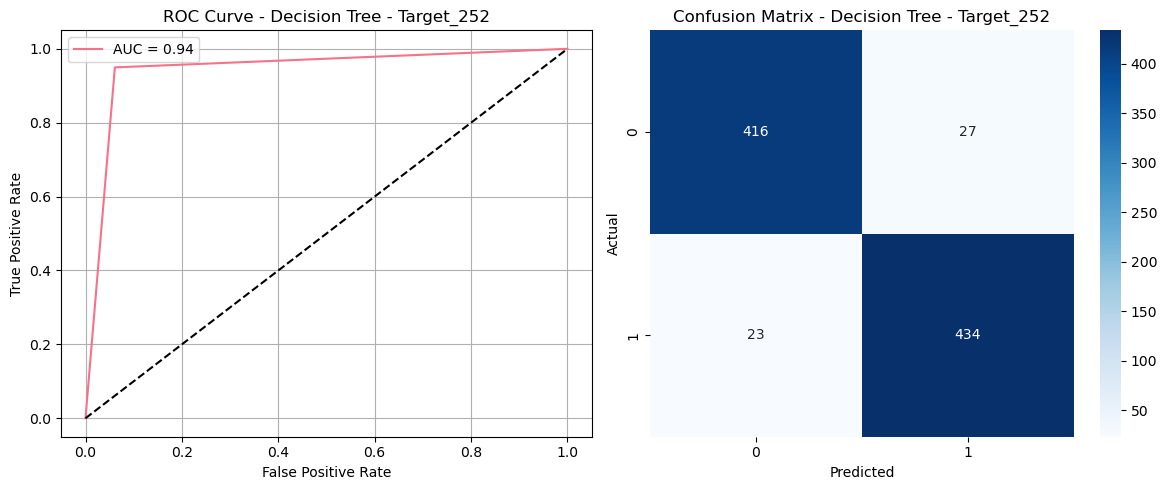

CV Accuracy for Logistic Regression on Target_252: 0.7736


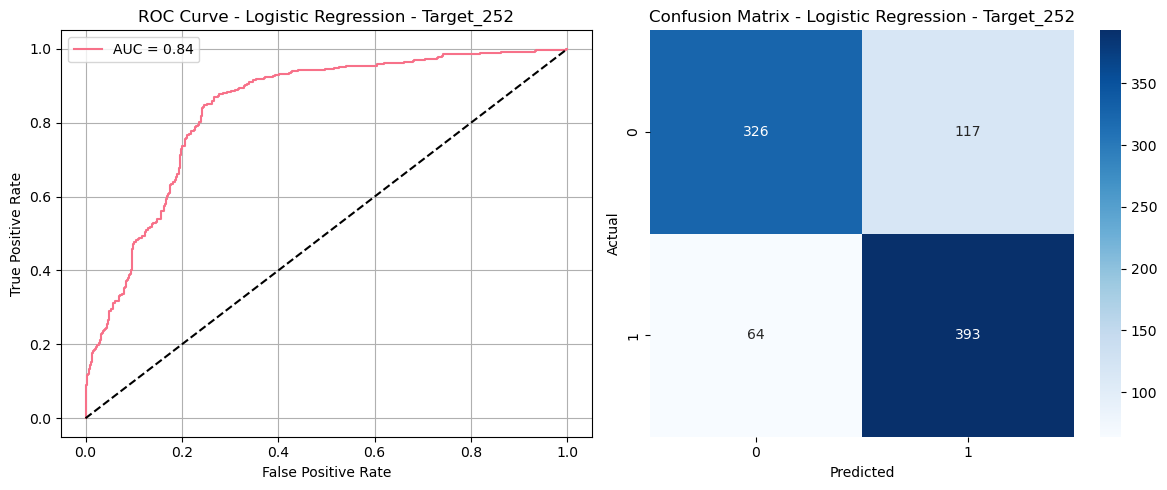

CV failed for XGBoost on Target_252: 'super' object has no attribute '__sklearn_tags__'


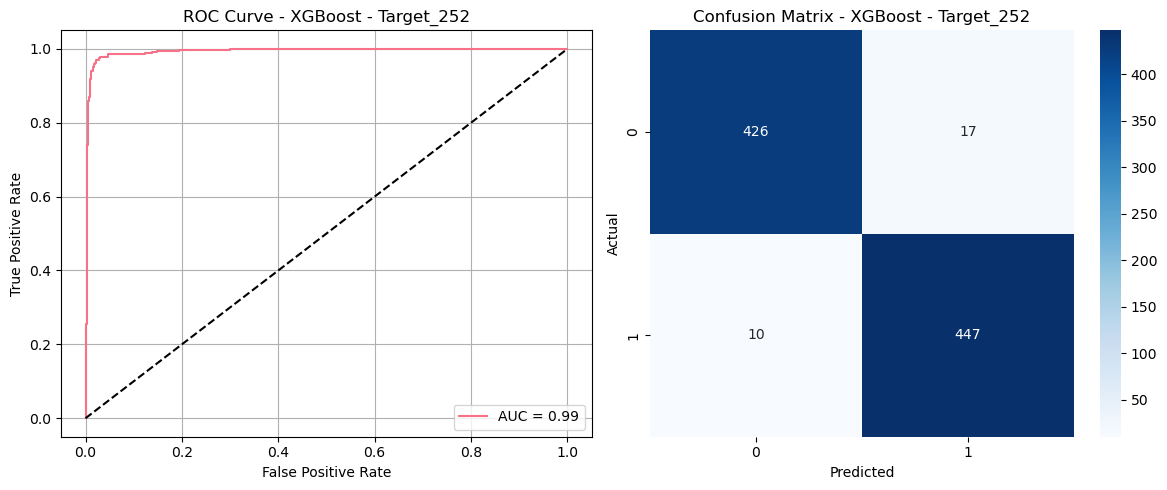

In [48]:
# Train and evaluate models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
feature_importances = {}

for target in targets:
    y = final_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
    
    target_results = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

        acc = accuracy_score(y_test, y_pred)
        roc = auc(*roc_curve(y_test, y_pred_proba)[:2]) if y_pred_proba is not None else None

        target_results[name] = {'accuracy': acc, 'roc_auc': roc}
        
        # 🔍 Feature importance for tree models
        if name in ['Random Forest', 'Decision Tree', 'XGBoost']:
            feature_importances[(target, name)] = model.feature_importances_

        # 🧪 Cross-validation
        try:
            cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
            print(f"CV Accuracy for {name} on {target}: {cv_scores.mean():.4f}")
        except Exception as e:
            print(f"CV failed for {name} on {target}: {e}")

       # 📊 Combined ROC Curve and Confusion Matrix Plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        # ROC Curve
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            axs[0].plot(fpr, tpr, label=f'AUC = {roc:.2f}')
            axs[0].plot([0, 1], [0, 1], 'k--')
            axs[0].set_title(f"ROC Curve - {name} - {target}")
            axs[0].set_xlabel("False Positive Rate")
            axs[0].set_ylabel("True Positive Rate")
            axs[0].legend()
            axs[0].grid(True)
        else:
            axs[0].text(0.5, 0.5, 'No ROC available', ha='center', va='center')
            axs[0].axis('off')
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axs[1])
        axs[1].set_title(f"Confusion Matrix - {name} - {target}")
        axs[1].set_xlabel("Predicted")
        axs[1].set_ylabel("Actual")
        
        # Save the combined plot
        plot_filename = f"{name.replace(' ', '_')}_{target}.png"
        plt.tight_layout()
        plt.savefig(plot_filename)
        plt.show()
        


    results[target] = target_results


Target: Target_1
Random Forest: Accuracy=0.5133, ROC_AUC=0.5204
KNN: Accuracy=0.5211, ROC_AUC=0.5176
Decision Tree: Accuracy=0.5033, ROC_AUC=0.5032
Logistic Regression: Accuracy=0.5178, ROC_AUC=0.5129
XGBoost: Accuracy=0.5244, ROC_AUC=0.5473

Target: Target_5
Random Forest: Accuracy=0.7900, ROC_AUC=0.8624
KNN: Accuracy=0.6356, ROC_AUC=0.6810
Decision Tree: Accuracy=0.6656, ROC_AUC=0.6640
Logistic Regression: Accuracy=0.5444, ROC_AUC=0.5331
XGBoost: Accuracy=0.7378, ROC_AUC=0.8187

Target: Target_21
Random Forest: Accuracy=0.9100, ROC_AUC=0.9600
KNN: Accuracy=0.7822, ROC_AUC=0.8473
Decision Tree: Accuracy=0.8500, ROC_AUC=0.8480
Logistic Regression: Accuracy=0.6100, ROC_AUC=0.5766
XGBoost: Accuracy=0.8878, ROC_AUC=0.9469

Target: Target_63
Random Forest: Accuracy=0.9478, ROC_AUC=0.9837
KNN: Accuracy=0.8156, ROC_AUC=0.8931
Decision Tree: Accuracy=0.8911, ROC_AUC=0.8889
Logistic Regression: Accuracy=0.6467, ROC_AUC=0.6380
XGBoost: Accuracy=0.9256, ROC_AUC=0.9785

Target: Target_126
Random

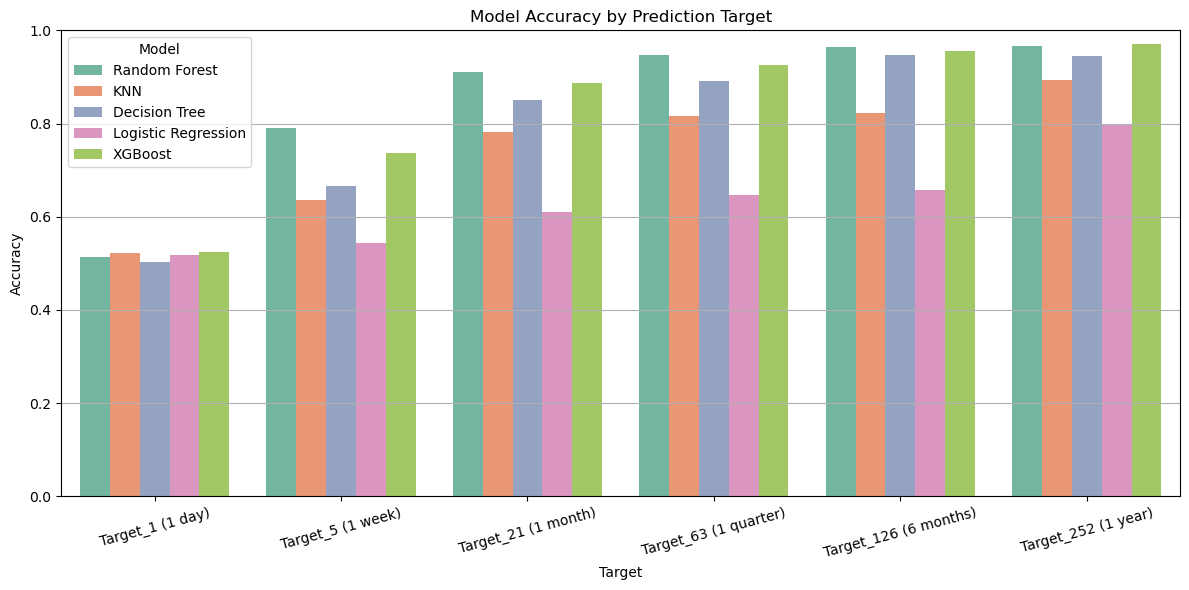

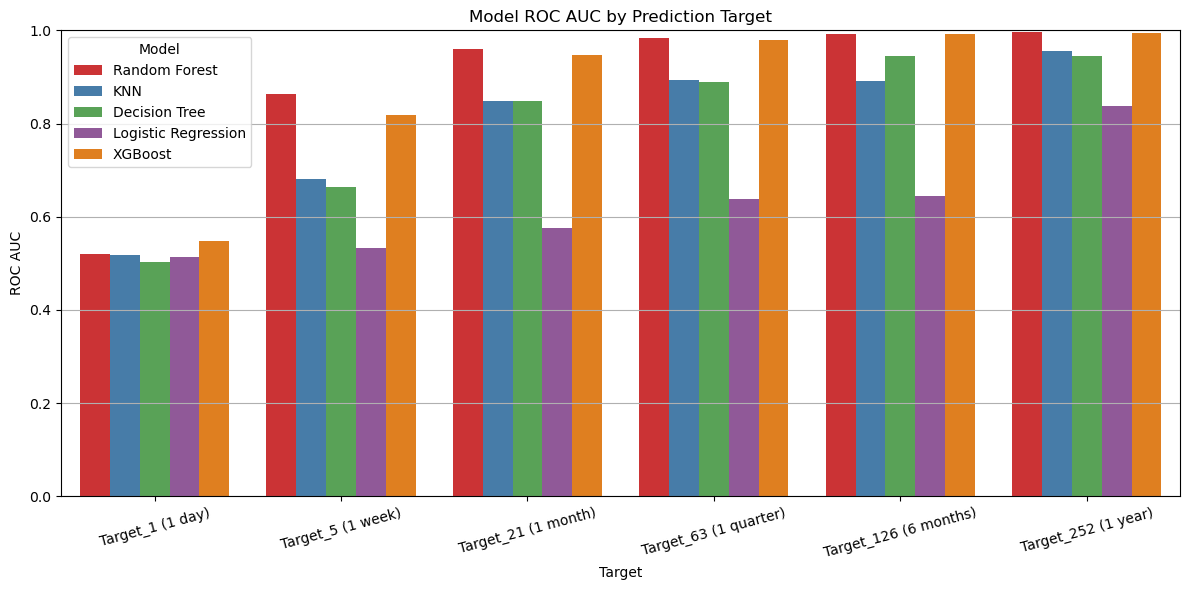

In [53]:
# Display summary results
for target, models_result in results.items():
    print(f"\nTarget: {target}")
    for model_name, metrics in models_result.items():
        acc_str = f"{metrics['accuracy']:.4f}"
        roc_auc_str = f"{metrics['roc_auc']:.4f}" if metrics['roc_auc'] is not None else "N/A"
        print(f"{model_name}: Accuracy={acc_str}, ROC_AUC={roc_auc_str}")


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping technical target names to user-friendly labels
target_mapping = {
    'Target_1': 'Target_1 (1 day)',
    'Target_5': 'Target_5 (1 week)',
    'Target_21': 'Target_21 (1 month)',
    'Target_63': 'Target_63 (1 quarter)',
    'Target_126': 'Target_126 (6 months)',
    'Target_252': 'Target_252 (1 year)'
}

# Step 1: Flatten the results dict to a DataFrame
summary_data = []
for target, models_result in results.items():
    for model_name, metrics in models_result.items():
        summary_data.append({
            'Target': target_mapping.get(target, target),  # Apply friendly label
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'ROC_AUC': metrics['roc_auc'] if metrics['roc_auc'] is not None else 0
        })

df = pd.DataFrame(summary_data)

# Step 2: Plot Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Target', y='Accuracy', hue='Model', palette='Set2')
plt.title('Model Accuracy by Prediction Target')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.legend(title='Model')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Step 3: Plot ROC AUC
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Target', y='ROC_AUC', hue='Model', palette='Set1')
plt.title('Model ROC AUC by Prediction Target')
plt.ylim(0, 1)
plt.ylabel('ROC AUC')
plt.xticks(rotation=15)
plt.legend(title='Model')
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [15]:
# ✅ Save and visualize
summary_df = pd.DataFrame([
    {'Target': t, 'Model': m, 'Accuracy': r['accuracy'], 'ROC_AUC': r['roc_auc']} 
    for t, v in results.items() for m, r in v.items()
])
summary_df.to_csv('model_performance_summary.csv', index=False)
summary_df.head()

,Target,Model,Accuracy,ROC_AUC
0,Target_1,Random Forest,0.513333,0.520405
1,Target_1,KNN,0.521111,0.517605
2,Target_1,Decision Tree,0.503333,0.503164
3,Target_1,Logistic Regression,0.517778,0.512857
4,Target_5,Random Forest,0.790000,0.862411
